## Testing the LESS Denoising Code 

In [1]:
%matplotlib widget

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import cv2
import sys
import pywt
from pathlib import Path
from IPython.display import display
import torch
less_path = os.path.abspath(os.path.join("..", "LESS_ver_alpha"))
if less_path not in sys.path:
    sys.path.insert(0, less_path)
from less import denoise
import seaborn as sns

In [2]:
print(torch.cuda.is_available())  # should return True
print(torch.cuda.get_device_name(0))  # your GPU name

True
NVIDIA GeForce RTX 2080 Ti


In [11]:
def movie_path(mouse, date, file):
    return "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF.h5'

path_movie = movie_path("cfm002mjr", 240510, 'meas00')
#path_movie = movie_path("cfm001mjr", 240518, 'meas00')

with h5py.File(path_movie, 'r') as mov_file:
    specs = mov_file["specs"]
    mov = mov_file['mov'][()][:10000]
    fps = specs['fps'][()][0][0][0]
    raw_mask = specs["extra_specs"]["mask"][()][0]
    binning = specs["binning"][()][0][0][0]  # Extract binning factor


In [12]:

def mask_movie(movie, raw_mask, binning):
    # Resize the mask using bilinear interpolation
    print(f"raw_mask shape: {None if raw_mask is None else raw_mask.shape}")
    print(f"binning: {binning}, fx: {1/binning}, fy: {1/binning}")
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning, interpolation=cv2.INTER_LINEAR)
    # Ensure mask has the same shape as the movie
    movie_size = movie.shape[1:3]  # Get spatial dimensions of the movie
    mask = mask[:movie_size[0], :movie_size[1]]  # Crop mask to match movie size
    mask = mask.astype(bool)         # Convert to boolean mask
    return movie * mask  # Apply mask


In [13]:
print(mov.shape)
movie = np.nan_to_num(mov)
movie_masked = mask_movie(movie, raw_mask, binning)

(10000, 188, 160)
raw_mask shape: (1280,)
binning: 8.0, fx: 0.125, fy: 0.125


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4214: error: (-215:Assertion failed) !dsize.empty() in function 'cv::resize'


In [4]:
def run_less_denoising(movie_np: np.ndarray,
                           patch_size: int = 16,
                           verbose: bool = False) -> np.ndarray:
    """
    Run LESS denoising on a NumPy movie array.

    Parameters:
        movie_np (np.ndarray): Input movie of shape (T, H, W)
        patch_size (int): Patch size
        top_k (int): Number of best-matching patches
        window_size (int): Search window size
        stride (int): Stride for patch selection
        pat (int): Temporal patch size (number of adjacent frames)
        seed (int): Random seed
        verbose (bool): Whether to print progress

    Returns:
        np.ndarray: Denoised movie of shape (T, H, W)
    """

    movie_tensor = torch.from_numpy(movie_np).float()

    denoised_tensor = denoise(
        data=movie_tensor,
        cuda=True,               
        patch_size=patch_size,
        verbose=verbose
    )

    return denoised_tensor.cpu().numpy()

In [ ]:
denoised = run_less_denoising(movie_np=movie_masked)

In [ ]:
def show_movie(frames, fps=50):
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], cmap='gray', vmin=frames.min(), vmax=frames.max(), aspect='auto')
    ax.axis("off")
    fig.set_size_inches(5, 5)  # Adjust for your aspect ratio

    def update(i):
        im.set_array(frames[i])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000/fps, blit=True)

    return ani

ani = show_movie(movie_masked)

In [8]:
def show_movies(original, denoised,  titles=("Original",  "Denoised"), save_path=None, fps=None):
    plt.close('all')  # Close any previously open figures

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ims = [ax.imshow(frames[0], cmap='gray', vmin=original.min(), vmax=original.max(), aspect='auto') 
           for frames, ax in zip([original, denoised], axes)]

    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.axis("off")
    
    def update(i):
        for im, frames in zip(ims, [original, denoised]):
            im.set_array(frames[i])
        return im

    ani = animation.FuncAnimation(fig, update, frames=len(original), interval=1000/fps, blit=True)

    if save_path:
        ani.save(save_path, writer="pillow", fps=fps)

    return ani

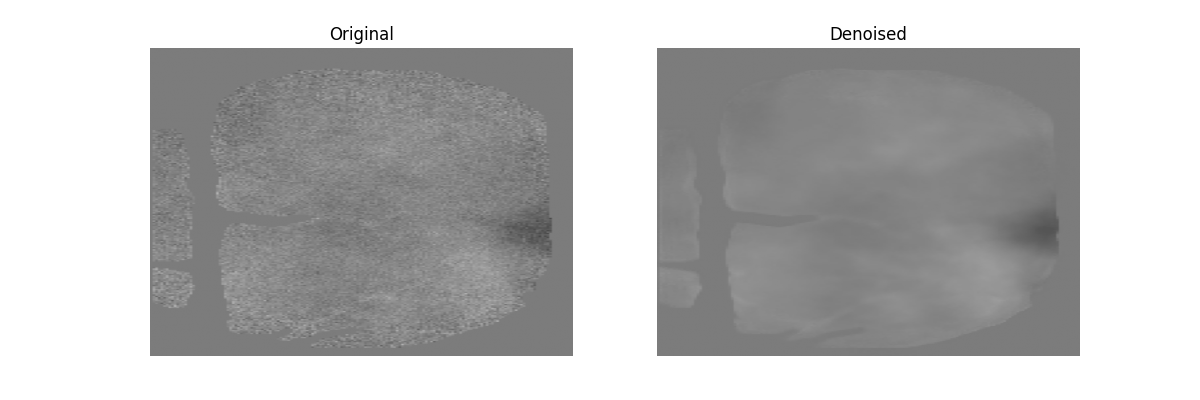

In [20]:
ani = show_movies(movie_masked, denoised, fps=fps)

In [8]:
mouse = "cfm001mjr"
date = "20240506"
file = "meas00"

noisy_path = f"N:/GEVI_Wave/Analysis/Visual/{mouse}/{date}/{file}/cG_unmixed_dFF.h5"
denoised_path = Path(noisy_path).with_name("cG_unmixed_dFF_denoised.h5")

# --- Load original (noisy) movie and compute stats ---
#with h5py.File(noisy_path, 'r') as f:
    #noisy_movie = np.nan_to_num(f['mov'][()][:1000])  # shape: (T, H, W)
    #fps = f["specs"]['fps'][()][0][0][0]

# --- Load denoised movie and compute stats ---
with h5py.File(denoised_path, 'r') as f:
    #denoised_movie = f['mov'][()][:1000]
    specs = f["specs"]

    for key in specs['extra_specs']:
        print(key)


F0
allenMapEdgeOutline
allenTransform
convertionDate
empty_spec
expBaseline_A
expBaseline_end
frange_valid
hardwareBinning
mask
recordingDate
timestamps
timestamps_table
timestamps_table_names


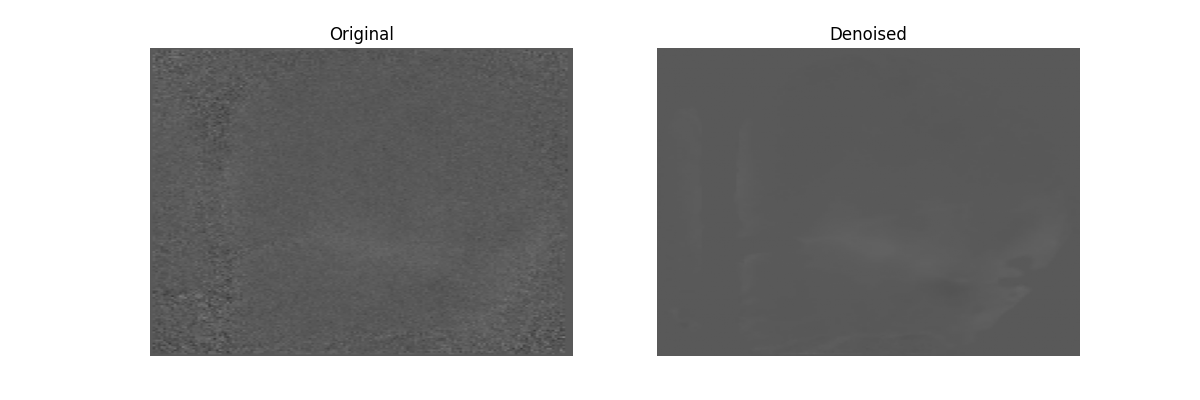

In [12]:
ani = show_movies(np.nan_to_num(noisy_movie), denoised_movie, fps=fps)

In [8]:
plt.close('all')

In [ ]:
def dynamic_spectrum(signal, fps):
    """
    Computes the dynamic spectrum (time-frequency array) of a 1D signal using the Complex Morlet Wavelet.
    Args:
    - signal (numpy.ndarray): 1D array representing the signal over time.
    - fps (float): Frames per second of the signal =
    Returns:
    - power_norm (numpy.ndarray): Normalized power of the wavelet transform.
    - frequencies (numpy.ndarray): Corresponding frequency values.
    """

    wavelet = 'cmor2.0-1.0'  # Complex Morlet wavelet

    # Define Frequency-Optimized Scales
    desired_freqs = np.linspace(1, 40, 100)
    scales = pywt.central_frequency(wavelet) * fps / desired_freqs

    # Compute Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1 / fps)
    power = np.abs(coefficients) ** 2  # Compute power spectrum

    # Keep Only Frequencies Below 30 Hz
    valid_idx = (frequencies >= 1.5) & (frequencies <= 40)
    frequencies = frequencies[valid_idx]
    scales = scales[valid_idx]
    power = power[valid_idx, :]  # Keep only low-frequency data
    power = power / scales[:, np.newaxis]
    
    return power, frequencies

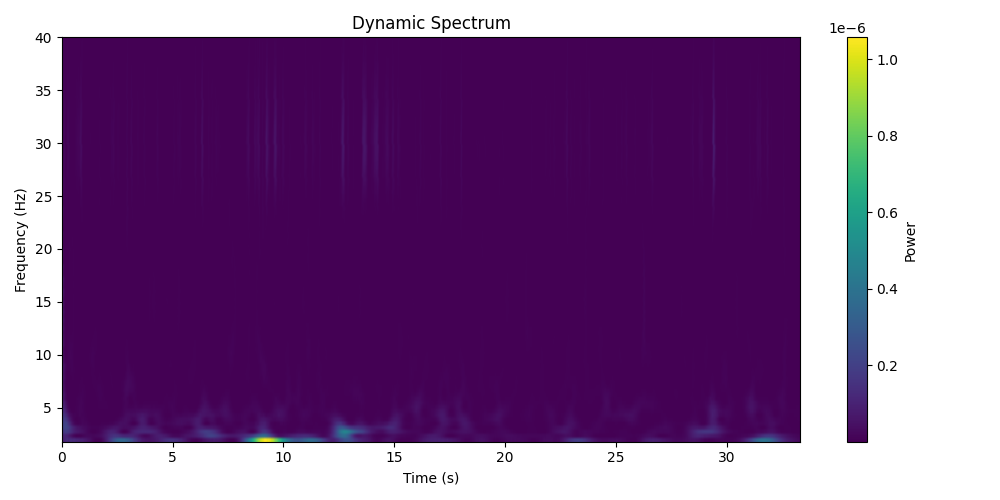

In [23]:
t = np.linspace(0, 2000, endpoint=False)

# Get dynamic spectrum
power, freqs = dynamic_spectrum(denoised.mean(axis=(1, 2)), fps)

# === Plotting ===
plt.figure(figsize=(10, 5))
extent = [0, len(denoised) / fps, freqs[0], freqs[-1]]
plt.imshow(power, aspect='auto', extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Dynamic Spectrum')
plt.tight_layout()
plt.show()